# Country-Billionaire Relationship

Is there a relationship between the economic development of countries and the number of billionaires? Can this relationship be explained by economic wealth distribution? Is there a difference between developed countries and developing countries?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Loading the data

In [3]:
# URL of the raw csv file in the GitHub repository
url = 'https://raw.githubusercontent.com/hcagatayyilmaz/data-literacy-extreme-wealth-analysis/main/Datasets/billionaires_2023.csv'

# Use pandas to import the csv file
df = pd.read_csv(url)

In [3]:
df.head()

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


In [4]:
df.columns

Index(['rank', 'finalWorth', 'category', 'personName', 'age', 'country',
       'city', 'source', 'industries', 'countryOfCitizenship', 'organization',
       'selfMade', 'status', 'gender', 'birthDate', 'lastName', 'firstName',
       'title', 'date', 'state', 'residenceStateRegion', 'birthYear',
       'birthMonth', 'birthDay', 'cpi_country', 'cpi_change_country',
       'gdp_country', 'gross_tertiary_education_enrollment',
       'gross_primary_education_enrollment_country', 'life_expectancy_country',
       'tax_revenue_country_country', 'total_tax_rate_country',
       'population_country', 'latitude_country', 'longitude_country'],
      dtype='object')

In [5]:
# Check for null values in each column
null_values = df.isnull().any()

# Count null values in each column
null_counts = df.isnull().sum()

null_percent = (round(null_counts/len(df),2)*100).astype(int)

# Create a new DataFrame
null_info_df = pd.DataFrame({
    'Has_Null': null_values,
    'Null_Count': null_counts,
    'Null_Percent': null_percent
})

# Display the result
print(null_info_df.sort_values(by='Null_Count', ascending=False))

                                            Has_Null  Null_Count  Null_Percent
organization                                    True        2315            88
title                                           True        2301            87
residenceStateRegion                            True        1893            72
state                                           True        1887            71
cpi_change_country                              True         184             7
cpi_country                                     True         184             7
tax_revenue_country_country                     True         183             7
total_tax_rate_country                          True         182             7
life_expectancy_country                         True         182             7
gross_tertiary_education_enrollment             True         182             7
gross_primary_education_enrollment_country      True         181             7
latitude_country                                True

In [6]:
# Drop the columns with almost only have null values
df.drop(["organization", "title", "state", "residenceStateRegion"], axis=1, inplace=True)

In [7]:
# Check for duplicates
df.duplicated().any()

False

In [8]:
# Convert 'gdp_country' to float by removing '$' and ','
df['gdp_country'] = df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)
print(df['gdp_country'].dtype)

float64


C:\Users\pulki\AppData\Local\Temp\ipykernel_14612\507803359.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['gdp_country'] = df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)


In [9]:
# To see whether we can fill null values in country column usign latitude and logitude columns:
condition_country = (df['country'].isnull()) & (df['longitude_country'].notnull()) & (df['latitude_country'].notnull())

# Check if there are any rows that satisfy the conditions
condition_country.any()

False

In [10]:
# Since country is an important feature for our analysis. We drop the rows with null country values
df.dropna(subset=['country'], inplace=True)

In [11]:
# To see if we can fill out null values in age column using birthDate or birthYear columns
condition_age = ((df['age'].isnull()) & ((df['birthDate'].notnull()) | df['birthYear'].notnull()))

# Check if there are any rows that satisfy the conditions
condition_age.any()

False

In [12]:
# Drop unnecessary columns
df.drop(["birthDay", "birthMonth", "birthYear"], axis=1, inplace=True)

In [13]:
# Convert 'birthDate' to datetime
df['birthDate'] = pd.to_datetime(df['birthDate'], errors='coerce')

In [14]:
# Specify the columns with missing values and the country column
columns_to_fill = ['cpi_country','cpi_change_country',
                   'gdp_country', 'gross_tertiary_education_enrollment',
                   'gross_primary_education_enrollment_country',
                   'life_expectancy_country', 'tax_revenue_country_country',
                   'total_tax_rate_country', 'population_country',
                   'latitude_country', 'longitude_country']

# Identify unique countries with complete information
complete_countries = df.dropna(subset=columns_to_fill + ['country'])[['country'] + columns_to_fill].drop_duplicates()

# Group by 'country' and fill missing values with corresponding country's values
df[columns_to_fill] = df.groupby('country')[columns_to_fill].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Drop duplicate rows based on all columns
df = df.drop_duplicates()

# Reset index after dropping duplicates
df = df.reset_index(drop=True)

# Missing values after filling
df[columns_to_fill].isnull().sum()

cpi_country                                   146
cpi_change_country                            146
gdp_country                                   126
gross_tertiary_education_enrollment           144
gross_primary_education_enrollment_country    143
life_expectancy_country                       144
tax_revenue_country_country                   145
total_tax_rate_country                        144
population_country                            126
latitude_country                              126
longitude_country                             126
dtype: int64

In [15]:
# Drop the remaining null values
df.dropna(inplace=True)

In [16]:
# Count the total number of rows with at least one missing value
total_missing_rows = (df.isnull().any(axis=1)).sum()

# Print the result
print(f'Total rows with missing values: {total_missing_rows}')

Total rows with missing values: 0


In [17]:
df.head()

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,2.715518e+12,65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


In [18]:
df.shape

(2369, 28)

In [19]:
df.columns

Index(['rank', 'finalWorth', 'category', 'personName', 'age', 'country',
       'city', 'source', 'industries', 'countryOfCitizenship', 'selfMade',
       'status', 'gender', 'birthDate', 'lastName', 'firstName', 'date',
       'cpi_country', 'cpi_change_country', 'gdp_country',
       'gross_tertiary_education_enrollment',
       'gross_primary_education_enrollment_country', 'life_expectancy_country',
       'tax_revenue_country_country', 'total_tax_rate_country',
       'population_country', 'latitude_country', 'longitude_country'],
      dtype='object')

Let’s calculate the GDP per capita and drop the ‘gdp_country’ and ‘population_country’ columns:

In [20]:
# Calculate GDP per capita
df['gdp_per_capita'] = df['gdp_country'] / df['population_country']


In [21]:
df.columns

Index(['rank', 'finalWorth', 'category', 'personName', 'age', 'country',
       'city', 'source', 'industries', 'countryOfCitizenship', 'selfMade',
       'status', 'gender', 'birthDate', 'lastName', 'firstName', 'date',
       'cpi_country', 'cpi_change_country', 'gdp_country',
       'gross_tertiary_education_enrollment',
       'gross_primary_education_enrollment_country', 'life_expectancy_country',
       'tax_revenue_country_country', 'total_tax_rate_country',
       'population_country', 'latitude_country', 'longitude_country',
       'gdp_per_capita'],
      dtype='object')

## Let's plot the country-wise number of billionaires for top 25 countries

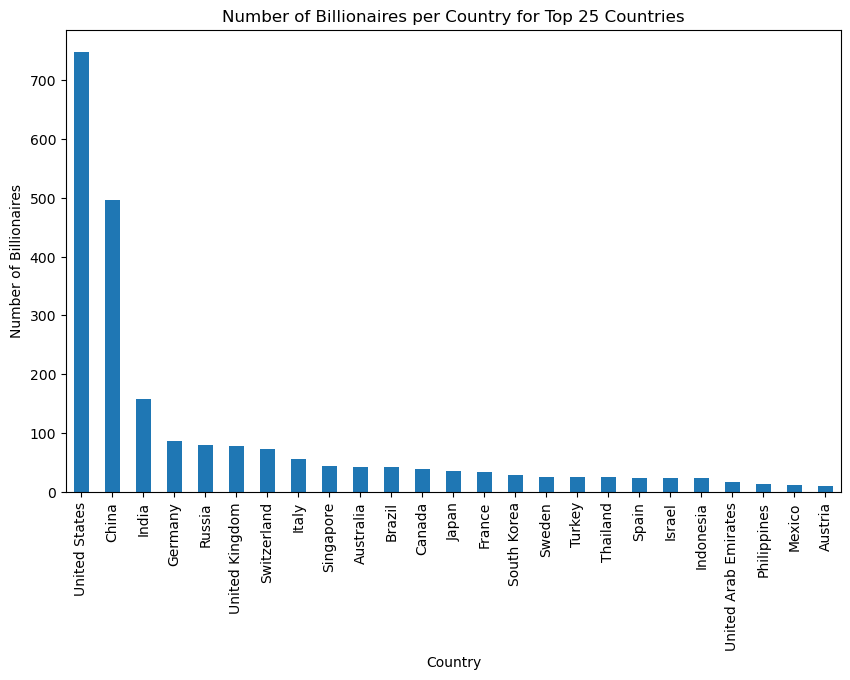

In [22]:
# Get the count of billionaires per country
billionaire_counts = df['country'].value_counts()

# Get the top 25 countries
top_25_countries = billionaire_counts[:25]

# Create the plot
plt.figure(figsize=(10, 6))
top_25_countries.plot(kind='bar')
plt.title('Number of Billionaires per Country for Top 25 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Billionaires')
plt.show()

In [23]:
# Print the names of the top 25 countries
print(top_25_countries.index.tolist())

['United States', 'China', 'India', 'Germany', 'Russia', 'United Kingdom', 'Switzerland', 'Italy', 'Singapore', 'Australia', 'Brazil', 'Canada', 'Japan', 'France', 'South Korea', 'Sweden', 'Turkey', 'Thailand', 'Spain', 'Israel', 'Indonesia', 'United Arab Emirates', 'Philippines', 'Mexico', 'Austria']


First, we calculated the number of billionaires for each country in the dataset. Then, we visualized this information by creating a bar plot showing the number of billionaires for the top 25 countries. These countries are: 'United States', 'China', 'India', 'Germany', 'Russia', 'United Kingdom', 'Switzerland', 'Italy', 'Singapore', 'Australia', 'Brazil', 'Canada', 'Japan', 'France', 'South Korea', 'Sweden', 'Turkey', 'Thailand', 'Spain', 'Israel', 'Indonesia', 'United Arab Emirates', 'Philippines', 'Mexico', 'Austria'. This analysis provides a clear picture of the distribution of billionaires across these countries.

Now we to normalize the count of billionaires by the population of each country, we will divide the number of billionaires in each country by the population of that country. This will give us the number of billionaires per capita, which is a more accurate measure of the concentration of billionaires in each country.

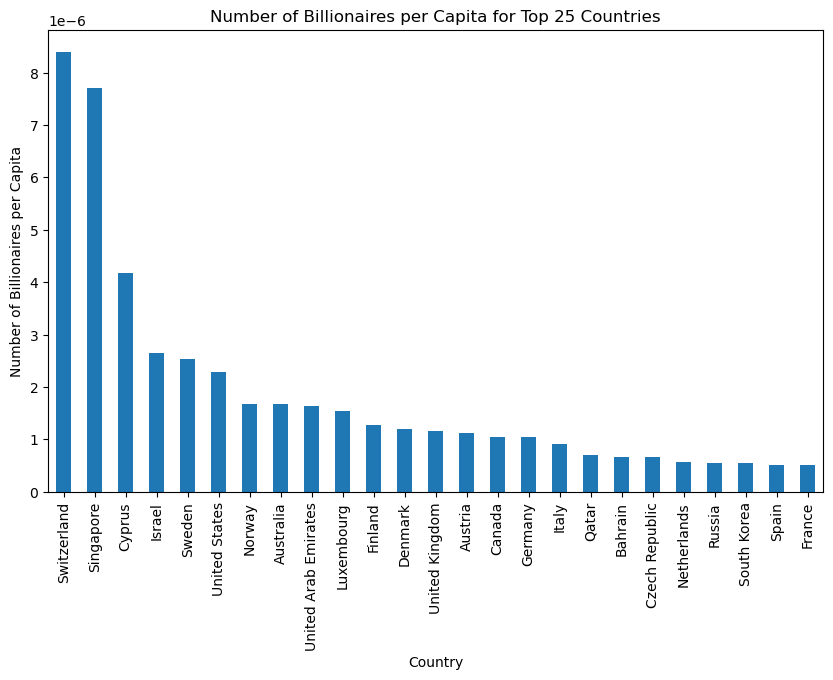

In [24]:
# Normalize the billionaire counts by the population of each country
normalized_counts = (df['country'].value_counts() / df.groupby('country')['population_country'].mean()).sort_values(ascending=False)

# Get the top 25 countries
top_25_normalized = normalized_counts[:25]

# Create the plot
plt.figure(figsize=(10, 6))
top_25_normalized.plot(kind='bar')
plt.title('Number of Billionaires per Capita for Top 25 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Billionaires per Capita')
plt.show()

In this step, we are adjusting the raw count of billionaires in each country by the country’s population to get a per capita figure. This gives us a more accurate picture of the concentration of billionaires in each country, as it takes into account the size of the country’s population. Countries with larger populations are likely to have more billionaires simply because they have more people. By normalizing by population, we can compare countries on an equal footing. 

We will now make subplots to make the comparison easier.

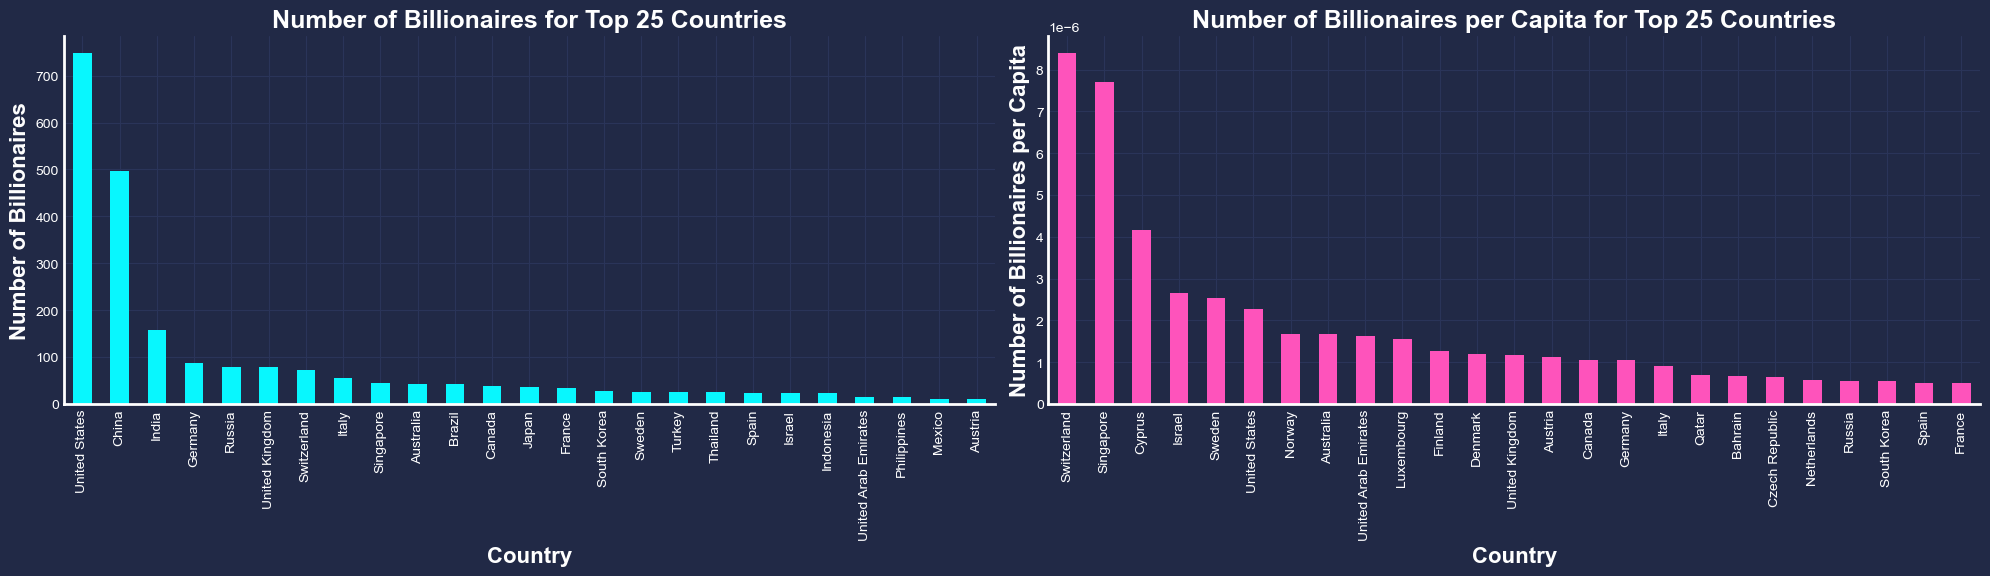

In [25]:
# Create a new style for mplcyberpunk
plt.style.use("cyberpunk")

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot for the number of billionaires
top_25_countries.plot(kind='bar', ax=axs[0], color='#08F7FE')  # teal/cyan
axs[0].set_title('Number of Billionaires for Top 25 Countries', fontsize=18, weight='bold', color='white')
axs[0].set_xlabel('Country', fontsize=16, weight='bold', color='white')
axs[0].set_ylabel('Number of Billionaires', fontsize=16, weight='bold', color='white')
axs[0].grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background
axs[0].spines['bottom'].set_color('white')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_color('white')
axs[0].spines['left'].set_linewidth(2)
axs[0].tick_params(colors='white')

# Plot for the number of billionaires per capita
top_25_normalized.plot(kind='bar', ax=axs[1], color='#FE53BB')  # pink
axs[1].set_title('Number of Billionaires per Capita for Top 25 Countries', fontsize=18, weight='bold', color='white')
axs[1].set_xlabel('Country', fontsize=16, weight='bold', color='white')
axs[1].set_ylabel('Number of Billionaires per Capita', fontsize=16, weight='bold', color='white')
axs[1].grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background
axs[1].spines['bottom'].set_color('white')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_color('white')
axs[1].spines['left'].set_linewidth(2)
axs[1].tick_params(colors='white')

plt.tight_layout()
plt.show()

In [26]:
print(top_25_normalized.index.tolist())

['Switzerland', 'Singapore', 'Cyprus', 'Israel', 'Sweden', 'United States', 'Norway', 'Australia', 'United Arab Emirates', 'Luxembourg', 'Finland', 'Denmark', 'United Kingdom', 'Austria', 'Canada', 'Germany', 'Italy', 'Qatar', 'Bahrain', 'Czech Republic', 'Netherlands', 'Russia', 'South Korea', 'Spain', 'France']


The top 25 countries with the highest number of billionaires per capita are quite different from the top 25 countries with the highest total number of billionaires. 

Countries like 'Switzerland', 'Singapore', 'Cyprus', 'Israel', and 'Sweden' have a high number of billionaires per capita, but they were not in the top 25 list for the total number of billionaires. This suggests that while these countries may have smaller populations, they have a high concentration of billionaires.

On the other hand, countries like 'China', 'India', and 'Russia' were in the top 25 list for the total number of billionaires, but they are not in the top 25 list for billionaires per capita. This could be due to their large populations diluting the per capita figure.

It's interesting to note that 'United States', 'Germany', 'United Kingdom', 'Australia', 'Canada', and 'Italy' appear in both lists. This indicates that these countries not only have a high total number of billionaires, but also a high number of billionaires relative to their population size.

This analysis provides a more nuanced understanding of the distribution of wealth across different countries.

## Heat map visual for billionaire_per_capita for each country

C:\Users\pulki\AppData\Local\Temp\ipykernel_14612\3924750167.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


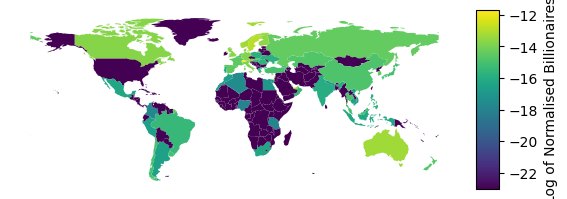

In [32]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Exclude Antarctica
world = world[(world.name != "Antarctica")]

# Calculate normalised billionaires per country and population per country
billionaires_per_country = df.groupby('country')['personName'].count()
population_per_country = df.groupby('country')['population_country'].mean()

# Normalise the number of billionaires by the population
normalised_billionaires = (billionaires_per_country / population_per_country).reset_index()
normalised_billionaires.columns = ['country', 'normalised_billionaires']

# Merge the world map with your data, filling missing values with zero
merged = world.set_index('name').join(normalised_billionaires.set_index('country'))
merged['normalised_billionaires'].fillna(0, inplace=True)

# Add a small constant to avoid taking log of zero
merged['normalised_billionaires'] += 1e-10

# Apply the logarithm to the data
merged['log_normalised_billionaires'] = np.log(merged['normalised_billionaires'])

# Plot the map
with plt.style.context('default'):
    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Use the min and max values for the color scale and a different colormap
    merged.plot(column='log_normalised_billionaires', ax=ax, legend=True, cmap='viridis', 
            legend_kwds={'label': "Log of Normalised Billionaires", 'orientation': "vertical"}, cax=cax)

    # Remove axes
    ax.axis('off')
    plt.show()



### Checking to see if there's a difference in the number of billionaires per capita in case of developed or developing countries


In [29]:
# List of developed countries
developed_countries = [
    "Andorra", "Antigua and Barbuda", "Aruba", "Australia", "Austria", 
    "Bahamas, The", "Bahrain", "Barbados", "Belgium", "Bermuda", 
    "British Virgin Islands", "Brunei Darussalam", "Canada", "Cayman Islands", 
    "Channel Islands", "Chile", "China", "Croatia", "Curaçao", "Cyprus", 
    "Czech Republic", "Denmark", "Estonia", "Faroe Islands", "Finland", 
    "France", "French Polynesia", "Germany", "Gibraltar", "Greece", 
    "Greenland", "Guam", "Hong Kong SAR, China", "Hungary", "Iceland", 
    "Ireland", "Isle of Man", "Israel", "Italy", "Japan", "Korea, Rep.", 
    "Kuwait", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", 
    "Macao SAR, China", "Malta", "Monaco", "Nauru", "Netherlands", 
    "New Caledonia", "New Zealand", "Northern Mariana Islands", "Norway", 
    "Oman", "Poland", "Portugal", "Puerto Rico", "Qatar", "San Marino", 
    "Saudi Arabia", "Seychelles", "Singapore", "Sint Maarten (Dutch part)", 
    "Slovak Republic", "Slovenia", "Spain", "St. Kitts and Nevis", 
    "St. Martin (French part)", "Sweden", "Switzerland", "Taiwan, China", 
    "Turkey", "Trinidad and Tobago", "Turks and Caicos Islands", 
    "United Arab Emirates", "United Kingdom", "United States", "Uruguay", 
    "Virgin Islands (U.S.)"
]

# Create a new column 'development_status'
df['development_status'] = df['country'].apply(lambda x: 'developed' if x in developed_countries else 'developing')
from scipy import stats

# Assuming 'df' is your DataFrame and it has a 'status' column 
# where countries are classified as either 'developing' or 'developed'

# Group by 'country' and count the number of billionaires
billionaires_per_country = df.groupby('country')['personName'].count()

# Get the population of each country
population_per_country = df.groupby('country')['population_country'].mean()

# Normalise the number of billionaires by the population
normalised_billionaires = billionaires_per_country / population_per_country

# Add 'normalised_billionaires' to the DataFrame
df['normalised_billionaires'] = df['country'].map(normalised_billionaires)


# Create two groups for developed and developing countries
group1 = df[df['development_status'] == 'developed']['normalised_billionaires']
group2 = df[df['development_status'] == 'developing']['normalised_billionaires']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')


T-statistic: 17.750499736129875
P-value: 2.7909773027379697e-66


The null hypothesis (H0) and alternative hypothesis (H1) for this t-test would be:

Null Hypothesis (H0): The mean of normalized billionaires is the same in developed and developing countries. In other words, there is no significant difference in the mean of normalized billionaires between developed and developing countries.

Alternative Hypothesis (H1): The mean of normalized billionaires is not the same in developed and developing countries. This means there is a significant difference in the mean of normalized billionaires between developed and developing countries.

The t-statistic of 17.75 is a measure of the difference between the means of the two groups (developed and developing countries) in terms of the number of billionaires normalized by population. A larger absolute value of the t-statistic indicates a more significant difference between the groups.

The p-value is extremely small, much less than 0.05 (a commonly used threshold for statistical significance at a 95% confidence level). This suggests that the observed difference between the two groups is statistically significant, and it is highly unlikely that this difference occurred by chance alone.

Therefore, we can infer that there is a statistically significant difference in the number of billionaires normalized by population between developed and developing countries. However, this test does not tell us about the nature of this difference (i.e., which group has more billionaires per capita). For that, you would need to look at the means of the two groups. 

Remember, while the t-test can indicate if there is a significant difference, it does not imply causation. Further investigation would be needed to understand the reasons behind this difference. It's also important to consider the limitations of the test and ensure the assumptions of the t-test are met (e.g., normal distribution, equal variances).

In [30]:
# Print the list of developed countries
print("Developed Countries:")
print(df[df['development_status'] == 'developed']['country'].unique())

# Print the list of developing countries
print("\nDeveloping Countries:")
print(df[df['development_status'] == 'developing']['country'].unique())


Developed Countries:
['France' 'United States' 'Spain' 'China' 'Canada' 'Germany' 'Switzerland'
 'Belgium' 'Austria' 'Japan' 'United Kingdom' 'Australia'
 'United Arab Emirates' 'Chile' 'Czech Republic' 'Sweden' 'Singapore'
 'Israel' 'Italy' 'New Zealand' 'Norway' 'Denmark' 'Netherlands' 'Poland'
 'Turkey' 'Portugal' 'Finland' 'Luxembourg' 'Oman' 'Cyprus' 'Greece'
 'Qatar' 'Uruguay' 'Hungary' 'Bahrain']

Developing Countries:
['Mexico' 'India' 'Indonesia' 'Russia' 'Thailand' 'Nigeria' 'South Africa'
 'Brazil' 'Malaysia' 'South Korea' 'Philippines' 'Egypt' 'Colombia'
 'Ukraine' 'Georgia' 'Kazakhstan' 'Algeria' 'Vietnam' 'Argentina'
 'Cambodia' 'Lebanon' 'Romania' 'Nepal' 'Slovakia' 'Morocco' 'Tanzania'
 'Peru' 'Armenia']


## Comparative Analysis of Billionaire Wealth Distribution in Developed and Developing Countries

In this analysis, we are investigating the distribution of billionaire wealth across developed and developing countries. We have a dataset of billionaires which includes their country of residence and other related features. We first categorized each country as either 'developed' or 'developing'. Then, we calculated the number of billionaires per capita for each country by normalizing the total number of billionaires by the country's population. This gives us a more accurate measure of billionaire concentration, as it accounts for differences in population size across countries. We then performed a t-test to statistically compare the mean number of billionaires per capita between developed and developing countries. Finally, we visualized our results using a boxplot, which provides a clear comparison of the distribution of normalized billionaire counts in developed and developing countries. This analysis provides valuable insights into the global distribution of extreme wealth.

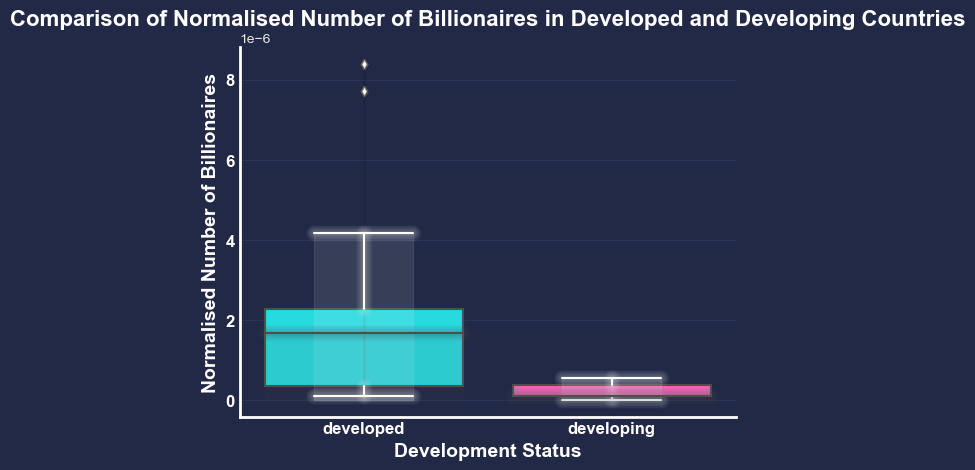

In [31]:
# Create a new style for mplcyberpunk
plt.style.use("cyberpunk")

# Create a boxplot with white whiskers, caps, and outliers
sns.boxplot(x='development_status', y='normalised_billionaires', data=df, 
            whiskerprops={'color': 'white'}, capprops={'color': 'white'}, flierprops={'markerfacecolor': 'white'})

# Add the cyberpunk style
mplcyberpunk.add_glow_effects()

# Set the title with increased font size and weight
plt.title('Comparison of Normalised Number of Billionaires in Developed and Developing Countries', fontsize=16, weight='bold', color='white')

# Set the x and y labels with increased font size and weight
plt.xlabel('Development Status', fontsize=14, weight='bold', color='white')
plt.ylabel('Normalised Number of Billionaires', fontsize=14, weight='bold', color='white')

# Increase the font size and weight of the ticks
plt.xticks(fontsize=12, weight='bold', color='white')
plt.yticks(fontsize=12, weight='bold', color='white')

# Make the axes bolder and white
ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('white')
ax.spines['left'].set_linewidth(2)

plt.show()


The boxplot in the image compares the normalized number of billionaires in developed and developing countries. The y-axis represents the normalized number of billionaires, and the x-axis categorizes the data into 'developed' and 'developing' countries.

From the plot, it's evident that developed countries have a significantly higher normalized number of billionaires compared to developing countries. This could be due to a variety of factors such as economic policies, market size, industrialization level, and availability of resources and opportunities.

However, it's important to note that there's a considerable amount of variation within each category, as indicated by the length of the boxes and whiskers in the plot. This suggests that there's a wide range of values within each category, and not all developed or developing countries have the same number of billionaires per capita.
